## Creating Biased Datasets Using Simstudy

In this notebook, we will be using Simstudy to simulate a dataset in which certain outcomes are biased, conditional on certain characteristics. We aim to demonstrate how Simstudy can be used to develop accelerators, as well as Trustworthy AI demos. By specifying the relationships between inputs and outputs ahead of time, we can see how well different algorithms do at estimating these relationships.

In [2]:
cd ../

/Users/davidcruz/Desktop/pysimstudy


In [3]:
import math
import pandas as pd
import numpy as np
import random
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt

from py_scripts.generate_dist import *
from py_scripts.group_data import *
from py_scripts.define_data import *
from py_scripts.generate_data import *
from py_scripts.add_data import *
from py_scripts.asserts import *

import statsmodels.api as sm

np.random.seed(42)

def coefasProb(coef):
    return np.exp(coef) / (1 + np.exp(coef))

Let's start with the building blocks of the pysimstudy package. 

The first step is to define a _definitions_ data table in which we describe the variables we want to generate. We pass arguments to define the generated variable's name (varname), as well as its statistical parameters. The _formula_ argument refers to the variable's mean, or expected value, and _variance_ is self evident. The _formula_ argument allows you to pass an equation to generate your data. In the example below, we want our __income__ variable to be centered at 0, but as we will see later on, we can also make the formula dependent on previously written data definitions to generate complex dependencies in the synthetic data. Note that the _variance_ argument is squared in this case, since the standard deviation is the square-root of variance.

We then define our target variable, __approval__. We add a new row to the data definitions table created in the previous lines of code by passing _df_ as the first argument. The _formula_ is defined as follows: the probability of an individual being approved is 50% +/- their relative income. In other words, inviduals who are on the higher (lower) end of the income scale will be more (less) likely to receive an approval.


In [57]:
ddf = defData(varname = "income", formula=1,
             variance=1, dist="normal")

# df = defData(df, varname = "region", formula="0.333, 0.333, 0.333",
#              variance="red, blue, green", dist="categorical")
             
ddf = defData(ddf, varname="approval", formula='0.5+(income/10)', dist='binary')

ddf

,varname,formula,variance,dist,link
0,income,1,1,normal,identity
1,approval,0.5+(income/10),0,binary,identity


Now that we 

In [115]:
gdf = genData(100000, ddf)
gdf.head()

,id,income,approval,region
0,0,0.073073,1,blue
1,1,0.411966,0,green
2,2,0.456583,1,red
3,3,-0.680989,1,green
4,4,0.277079,1,blue


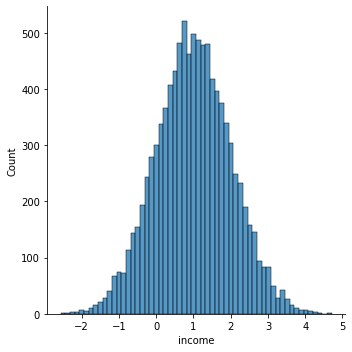

In [56]:
sns.displot(gdf['income'])

In certain cases, the formula and variance arguments are used differently. For instance, when defining a categorical data definition, the _formula_ argument is used to determine the categories' respective probabilities of being drawn, and the _variance_ argument defines the categories' names. 

In [18]:
# defC = defCondition(condition = "color=='blue'", formula = "0.1", variance = "0.1",
#                     dist = "normal")

# defC = defCondition(defC, condition = "color!='blue'", formula = "0", variance = "0.1",
#                     dist = "normal")

# df3 = addCondition(defC, df2, newvar="income")

## Case 2 - Biased Data

### Sub-Scenario 1 - Direct bias

In this example we introduce categorical distribution named "region". This shows a uniform distribution of observations belonging to one of three regions based on color. Our income is still normally distributed across the population, but there is going to be a protected class that gets "discriminated" against to simulate direct bias. In this case, if you're in the blue region, you will be approved 10% less of the time.

here we demonstrate the defCondition function which is used for conditional distributions ... 

In [116]:
ddf = defData(ddf, varname = "region", formula="0.333, 0.333, 0.333",
             variance="red, blue, green", dist="categorical")

ddf

Exception: Variable name already exists

In [117]:
gdf2 = genData(100000, ddf)
gdf2.head()

,id,income,approval,region
0,0,1.242047,0,red
1,1,0.954866,1,green
2,2,1.503531,1,blue
3,3,2.219060,1,green
4,4,1.153689,0,red


below shows blue region have 10% less approval, since we have hard coded a 10% less probability of getting a loan approved

In [118]:
defC = defCondition(condition = "region=='blue'", formula = "0.4+income/10",
                    dist = "binary")

defC = defCondition(defC, condition = "region!='blue'", formula = "0.5+income/10",
                    dist = "binary")

gdf2 = addCondition(defC, gdf2, newvar="approval_bias")

In [67]:
gdf2

,id,income,approval,region,approval_bias
0,2,0.366992,1,blue,1
1,7,1.675522,1,blue,0
2,9,2.261055,1,blue,1
3,10,-0.177931,0,blue,0
4,11,0.749448,1,blue,1
...,...,...,...,...,...
9995,9989,3.272209,1,green,1
9996,9990,1.234276,1,red,0
9997,9991,0.000309,0,red,0
9998,9993,1.098934,1,red,1


<AxesSubplot:xlabel='approval', ylabel='Count'>

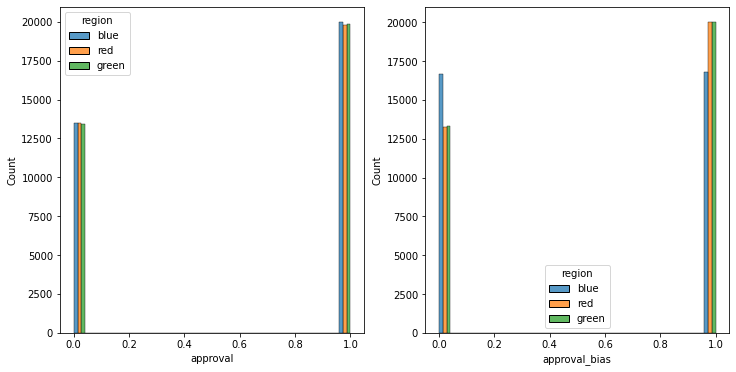

In [119]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sns.histplot(
    data=gdf2, x='approval_bias', hue='region', multiple='dodge',
    # bins=range(1, 110, 10),
    ax=ax[1]
)

sns.histplot(
    data=gdf2, x='approval', hue='region', multiple='dodge',
    # bins=range(1, 110, 10),
    ax=ax[0]
)

### subscenario 2
it is also possible to have indirect bias
here blue region get a 20% less income negative bonus


In [158]:
defIncomeBiased = defCondition(condition = "region=='blue'", 
                    formula = "0.9*income",
                    dist = "nonrandom")

In [159]:
gdf3 = addCondition(defIncomeBiased, gdf2, newvar="income_bias", keepOld=True)

In [160]:
gdf3.groupby('region')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
blue,33441.0,0.997027,1.003483,-2.817797,0.317139,1.003377,1.671290,5.153257
green,33304.0,0.996494,0.999255,-3.189234,0.317654,0.993076,1.676641,5.678949
red,33255.0,1.003764,1.000917,-3.121696,0.330992,1.004371,1.681318,4.811216


In [161]:
gdf3.groupby('region')['income_bias'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
blue,33441.0,0.897324,0.903135,-2.536018,0.285425,0.903039,1.504161,4.637932
green,33304.0,0.996494,0.999255,-3.189234,0.317654,0.993076,1.676641,5.678949
red,33255.0,1.003764,1.000917,-3.121696,0.330992,1.004371,1.681318,4.811216


In [149]:
gdf3

,id,income,approval,region,approval_bias,income_bias
0,2,1.503531,1,blue,1,0.933034
1,8,2.271253,1,blue,1,1.741540
2,9,2.327749,1,blue,0,2.145719
3,16,2.865286,1,blue,0,1.518266
4,17,3.174979,1,blue,0,3.776487
...,...,...,...,...,...,...
99995,99991,1.880819,1,green,0,1.880819
99996,99992,0.730941,1,green,1,0.730941
99997,99994,3.285242,0,green,1,3.285242
99998,99996,1.867304,1,red,1,1.867304


In [162]:
defIndirectBiasApproval = defData(varname = "approval_indirect_bias", dist = "binary", formula = "0.5+(income_bias/10)",)
gdf3 = addColumns(defIndirectBiasApproval, gdf3)

In [163]:
gdf3.groupby('region')['approval_indirect_bias'].value_counts(normalize=True)

region  approval_indirect_bias
blue    1                         0.591579
        0                         0.408421
green   1                         0.599357
        0                         0.400643
red     1                         0.600481
        0                         0.399519
Name: approval_indirect_bias, dtype: float64

In [164]:
gdf3.groupby('region')['approval'].value_counts(normalize=True)

region  approval
blue    1           0.597052
        0           0.402948
green   1           0.596715
        0           0.403285
red     1           0.594768
        0           0.405232
Name: approval, dtype: float64

In [165]:
gdf3['const'] = 1

In [166]:
X = pd.get_dummies(gdf3.drop(['id', 'region', 'income', 'approval', 'approval_bias', 'approval_indirect_bias'], axis = 1))

mod = sm.GLM(gdf3['approval_indirect_bias'],
             X ,
            family=sm.families.Binomial())

res = mod.fit()

print(res.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     approval_indirect_bias   No. Observations:               100000
Model:                                GLM   Df Residuals:                    99998
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -65409.
Date:                    Thu, 20 Oct 2022   Deviance:                   1.3082e+05
Time:                            13:51:47   Pearson chi2:                 9.99e+04
No. Iterations:                         5                                         
Covariance Type:                nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
income_bia

In [167]:
X = pd.get_dummies(gdf3.drop(['id', 'income', 'approval', 'approval_bias', 'approval_indirect_bias'], axis = 1))

mod = sm.GLM(gdf3['approval_indirect_bias'],
             X ,
            family=sm.families.Binomial())

res = mod.fit()

print(res.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     approval_indirect_bias   No. Observations:               100000
Model:                                GLM   Df Residuals:                    99996
Model Family:                    Binomial   Df Model:                            3
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -65409.
Date:                    Thu, 20 Oct 2022   Deviance:                   1.3082e+05
Time:                            13:52:31   Pearson chi2:                 9.99e+04
No. Iterations:                        14                                         
Covariance Type:                nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
income_b

In [15]:
# the coefficient of red as a probability
coefasProb(0.1274)

0.5318069906639059

## Case Study 2: What happens when Blue is a minority category?

In [16]:
df = defData(varname = "color", formula="0.55, 0.10, 0.35",
             variance="red, blue, green", dist="categorical")
             
df = defData(df, varname = "income", formula=0,
             variance=1, dist="normal")
             
df = defData(df, varname="approval", formula='0.5', dist='binary')

df2 = genData(10000, df)

defC = defCondition(condition = "color=='blue'", formula = "0.4+income/10",
                    dist = "binary")

defC = defCondition(defC, condition = "color!='blue'", formula = "0.5+income/10",
                    dist = "binary")

df3 = addCondition(defC, df2, newvar="approval_bias")

<AxesSubplot:xlabel='approval_bias', ylabel='Count'>

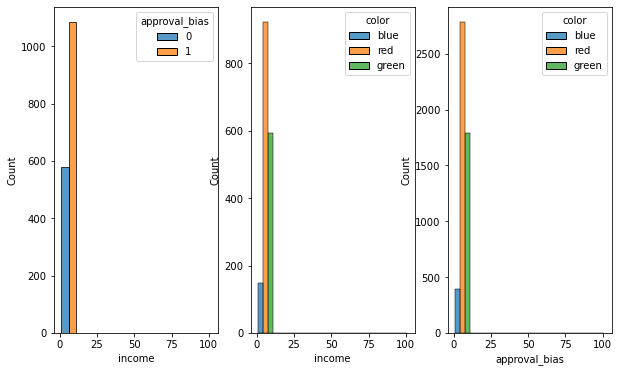

In [17]:
fig, ax = plt.subplots(1,3, figsize = (10,6))
sns.histplot(
    data=df3, x='income', hue='approval_bias', multiple='dodge',
    bins=range(1, 110, 10),
    ax=ax[0]
)

sns.histplot(
    data=df3, x='income', hue='color', multiple='dodge',
    bins=range(1, 110, 10),
    ax=ax[1]
)

sns.histplot(
    data=df3, x='approval_bias', hue='color', multiple='dodge',
    bins=range(1, 110, 10),
    ax=ax[2]
)

In [18]:
df3['const'] = 1
mod = sm.GLM(df3['approval_bias'], pd.get_dummies(df3.drop(['id', 'approval_bias'], axis = 1)),
family=sm.families.Binomial())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          approval_bias   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6680.3
Date:                Thu, 25 Aug 2022   Deviance:                       13361.
Time:                        17:08:13   Pearson chi2:                 1.00e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04895
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.4390      0.021     20.608      

In [19]:
# the coefficient of blue as a prb
coefasProb(-0.3194)

0.4208219794045014

In [20]:
# the coefficient of red as a prb
coefasProb(0.0854)

0.5213370337092745

In [21]:
# the coefficient of green as a prob
coefasProb(0.1364)

0.5340472290832388

## Case Study 3

Let's add some predictor variables

And make a couple of them correlated with color

Then regress approval on these variables, excluding color

In [22]:
df = defData(varname = "eye_color", formula="0.55, 0.10, 0.35",
             variance="red, blue, green", dist="categorical")

df = defData(df, varname = "gender", formula=0.5,
            dist="binary")
             
df2 = genData(10000, df)

defNeighborhood = defCondition(condition = "eye_color=='blue'", 
                    formula = "0.75, 0.05, 0.05, 0.15",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defNeighborhood = defCondition(defNeighborhood, condition = "eye_color=='red'", 
                    formula = "0.05, 0.55, 0.2, 0.2",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defNeighborhood = defCondition(defNeighborhood, condition = "eye_color=='green'", 
                    formula = "0.2, 0.4, 0.3, 0.1",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defEdu = defCondition(condition = "eye_color=='blue'", 
                    formula = "0.65, 0.25, 0.1",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defEdu = defCondition(defEdu, condition = "eye_color=='red'", 
                    formula = "0.2, 0.3, 0.5",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defEdu = defCondition(defEdu, condition = "eye_color=='green'", 
                    formula = "0.3, 0.4, 0.3",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defIncome = defCondition(condition = "education=='e1'", 
                    formula = 500,
                    variance = 100**2,
                    dist = "normal")

defIncome = defCondition(defIncome, condition = "education=='e2'", 
                    formula = 750,
                    variance = 125**2,
                    dist = "normal")

defIncome = defCondition(defIncome, condition = "education=='e3'", 
                    formula = 1500,
                    variance = 250**2,
                    dist = "normal")

efIncomeBiased = defCondition(condition = "eye_color=='blue'", 
                    formula = "0.9*income_raw",
                    dist = "nonrandom")

defIncomeBiased = defCondition(defIncomeBiased, condition = "eye_color!='blue'", 
                    formula = "income_raw",
                    dist = "nonrandom")
d
defIncomeBiasedGender = defCondition(condition = "gender==0", 
                        formula = "0.95*income_biased",
                        dist = "nonrandom")

defIncomeBiasedGender = defCondition(defIncomeBiasedGender, condition = "gender==1", 
                        formula = "income_biased",
                        dist = "nonrandom")

df3 = addCondition(defNeighborhood, df2, newvar="neighborhood")
df3 = addCondition(defEdu, df3, newvar="education")
df3 = addCondition(defIncome, df3, newvar="income_raw")
df3 = addCondition(defIncomeBiased, df3, newvar="income_biased")
df3 = addCondition(defIncomeBiasedGender, df3, newvar="income_biased2")

In [23]:
defNeighborhood

,condition,formula,variance,dist,link
0,eye_color=='blue',"0.75, 0.05, 0.05, 0.15","N1, N2, N3, N4",categorical,identity
0,eye_color=='red',"0.05, 0.55, 0.2, 0.2","N1, N2, N3, N4",categorical,identity
0,eye_color=='green',"0.2, 0.4, 0.3, 0.1","N1, N2, N3, N4",categorical,identity


In [24]:
df3.groupby('eye_color')['education'].value_counts()

eye_color  education
blue       e1            654
           e2            235
           e3             98
green      e2           1487
           e1           1054
           e3           1052
red        e3           2731
           e2           1623
           e1           1066
Name: education, dtype: int64

In [25]:
df3.groupby('eye_color')['income_raw'].mean()

eye_color
blue      664.443871
green     893.520432
red      1076.719182
Name: income_raw, dtype: float64

In [26]:
m = df3['income_biased2'].mean()
s = df3['income_biased2'].std()
df3['income_standard'] = df3['income_biased2'].apply(lambda x: (x - m) / s)

In [27]:
df3.groupby('eye_color')['income_standard'].mean()

eye_color
blue    -0.782554
green   -0.148838
red      0.241172
Name: income_standard, dtype: float64

Income is the only factor directly influencing approval

In [28]:
defTarget =  defData(varname = "approval", dist = "binary", formula = "0.5+(income_standard/10)",)
defTarget

,varname,formula,variance,dist,link
0,approval,0.5+(income_standard/10),0,binary,identity


But, income is biased based on previous conditions

In [29]:
df3 = addColumns(defTarget, df3)

In [30]:
df3

,id,eye_color,gender,neighborhood,education,income_raw,income_biased,income_biased2,income_standard,approval
0,32,blue,0,N4,e1,411.141290,370.027161,351.525803,-1.290413,0
1,77,blue,0,N1,e1,438.338918,394.505026,374.779775,-1.239418,0
2,115,blue,0,N1,e1,424.648182,382.183364,363.074195,-1.265087,0
3,171,blue,0,N1,e1,512.397416,461.157674,438.099790,-1.100559,1
4,204,blue,0,N1,e1,580.599278,522.539350,496.412383,-0.972682,0
...,...,...,...,...,...,...,...,...,...,...
9995,9926,green,1,N1,e3,1653.898980,1653.898980,1653.898980,1.565638,0
9996,9950,green,1,N2,e3,1130.632131,1130.632131,1130.632131,0.418135,1
9997,9981,green,1,N1,e3,1667.966166,1667.966166,1667.966166,1.596486,1
9998,9985,green,1,N2,e3,2022.897736,2022.897736,2022.897736,2.374836,1


In [31]:
os.getcwd()

'/Users/davidcruz/Desktop/Side_Projects/simulacra-fake-data'

In [32]:
df3.to_csv('/Users/davidcruz/Desktop/Side_Projects/simulacra-fake-data/approval-fake.csv')

In [33]:
df3.groupby('eye_color')['approval'].value_counts(normalize=True)

eye_color  approval
blue       0           0.568389
           1           0.431611
green      0           0.523518
           1           0.476482
red        1           0.519373
           0           0.480627
Name: approval, dtype: float64

In [34]:
df3.groupby('education')['approval'].value_counts(normalize=True)

education  approval
e1         0           0.614996
           1           0.385004
e2         0           0.536622
           1           0.463378
e3         1           0.601649
           0           0.398351
Name: approval, dtype: float64

In [35]:
df3['const'] = 1
mod = sm.GLM(df3['approval'], pd.get_dummies(df3.drop(['id', 'approval', 'income_raw', 
            'income_biased', 'income_biased2'], axis = 1)),
            family=sm.families.Binomial())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               approval   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6726.4
Date:                Thu, 25 Aug 2022   Deviance:                       13453.
Time:                        17:08:14   Pearson chi2:                 1.00e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04011
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gender              0.0066      0.041     

In [36]:
coefasProb(-0.0563)

0.4859287166041853

In [37]:
coefasProb(0.0305)

0.5076244089586274

In [38]:
coefasProb(0.0075)

0.5018749912109869

In [39]:
df3['const'] = 1
mod = sm.GLM(df3['approval'], pd.get_dummies(df3.drop(['id', 'approval', 'income_raw', 'eye_color',
            'income_biased', 'income_biased2'], axis = 1)),
            family=sm.families.Binomial())
            
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               approval   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9992
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6727.3
Date:                Thu, 25 Aug 2022   Deviance:                       13455.
Time:                        17:08:14   Pearson chi2:                 1.00e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.03992
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gender              0.0071      0.041     

In [40]:
df3.columns

Index(['id', 'eye_color', 'gender', 'neighborhood', 'education', 'income_raw',
       'income_biased', 'income_biased2', 'income_standard', 'approval',
       'const'],
      dtype='object')

In [41]:
pd.get_dummies(df3.drop(['id', 'approval', 'income_raw', 
            'income_biased', 'income_biased2'], axis = 1))

,gender,income_standard,const,eye_color_blue,eye_color_green,eye_color_red,neighborhood_N1,neighborhood_N2,neighborhood_N3,neighborhood_N4,education_e1,education_e2,education_e3
0,0,-1.290413,1,1,0,0,0,0,0,1,1,0,0
1,0,-1.239418,1,1,0,0,1,0,0,0,1,0,0
2,0,-1.265087,1,1,0,0,1,0,0,0,1,0,0
3,0,-1.100559,1,1,0,0,1,0,0,0,1,0,0
4,0,-0.972682,1,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1.565638,1,0,1,0,1,0,0,0,0,0,1
9996,1,0.418135,1,0,1,0,0,1,0,0,0,0,1
9997,1,1.596486,1,0,1,0,1,0,0,0,0,0,1
9998,1,2.374836,1,0,1,0,0,1,0,0,0,0,1


In [42]:
from sklearn.utils import compute_sample_weight, resample

from sklearn.model_selection import  train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import tree

from sklearn.metrics import classification_report, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

In [43]:
X = df3.drop(['id', 'approval', 'income_raw',
            'income_biased', 'income_biased2'], axis = 1)

In [44]:
y = df3['approval']

In [45]:
# establish categorical variables in X
categorical = X.dtypes == object
# preprocessing pipeline
preprocess = make_column_transformer(
    (StandardScaler(), ~categorical),
    (OneHotEncoder(handle_unknown = 'ignore'), categorical)
)

cv = KFold(n_splits = 5)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = make_pipeline(preprocess, LogisticRegression())
model.fit(X_train, y_train);

In [47]:
cat_names = ['eye_color', 'neighborhood', 'education']
final_feature_names = categorical[~categorical].index.values.tolist() + \
                      preprocess.transformers_[1][1].get_feature_names_out(cat_names).tolist()

coefs = model.named_steps['logisticregression'].coef_[0]

featureImportance_df = pd.Series(data = coefs, 
                                 index = final_feature_names, 
                                 name = 'coefs').\
                        sort_values(ascending = False, key = np.abs)

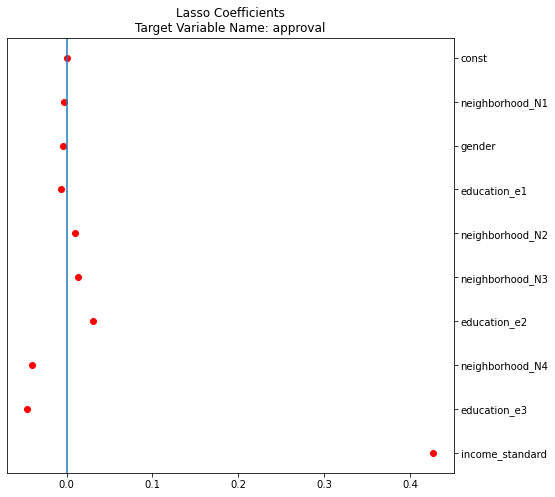

In [48]:
# setting a y_axis variable allows to flip chart for easier reading        
yax = np.arange(len(featureImportance_df))

fig, ax = plt.subplots(1, 1, figsize = (8,8))

ax.plot(featureImportance_df, yax, 'o', c='r')
ax.set_yticks(range(len(featureImportance_df)))
ax.yaxis.tick_right()
ax.set_yticklabels(featureImportance_df.index,rotation = 0)
ax.set_title('lasso'.capitalize()+' Coefficients\nTarget Variable Name: '+str(y.name))
ax.axvline(0)

plt.show()

In [55]:
df3[df3['eye_color'] == 'blue']['neighborhood'].value_counts(normalize=True)

N1    0.766971
N4    0.145897
N2    0.053698
N3    0.033435
Name: neighborhood, dtype: float64

In [50]:
X_train

,gender,neighborhood,education,income_standard,const
8371,1,N2,e3,0.941888,1
5027,1,N1,e1,-0.454713,1
9234,1,N2,e3,1.829816,1
3944,0,N2,e3,0.861143,1
6862,1,N2,e2,-0.206780,1
...,...,...,...,...,...
5734,1,N2,e1,-0.902034,1
5191,1,N1,e1,-1.043161,1
5390,1,N1,e3,0.759118,1
860,0,N2,e1,-1.016227,1


In [51]:
X_train['gender'].value_counts()[X_train['gender'].value_counts() > 1].reset_index()['gender']

0    3445
1    3255
Name: gender, dtype: int64

In [52]:
y_pred = model.predict(X_test)